# CSM148 Final Project

*Prithvi Kannan*

*UID: 405110096*


In [10]:
# relevant imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

### Load data

In [11]:
data = pd.read_csv(os.getcwd() + "/healthcare-dataset-stroke-data.csv")

**Data Fields**
- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension 5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- stroke: 1 if the patient had a stroke or 0 if not

### Basic Statistics

In [12]:
# first 5 rows
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [13]:
# summary info to understand the different data types in the table
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


* there are only 4909 non-null values for BMI, so we will need to impute missing data
* we will need to encode boolean data such as `gender`, `ever_married`, `residence_type`
* we will need to encode categorical data such as `work_type`, `smoking_status`

In [14]:
# statistics for the numerical features in the table
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


* numerical features are on very difference scales (glucose mean is 106 and BMI mean is 29)

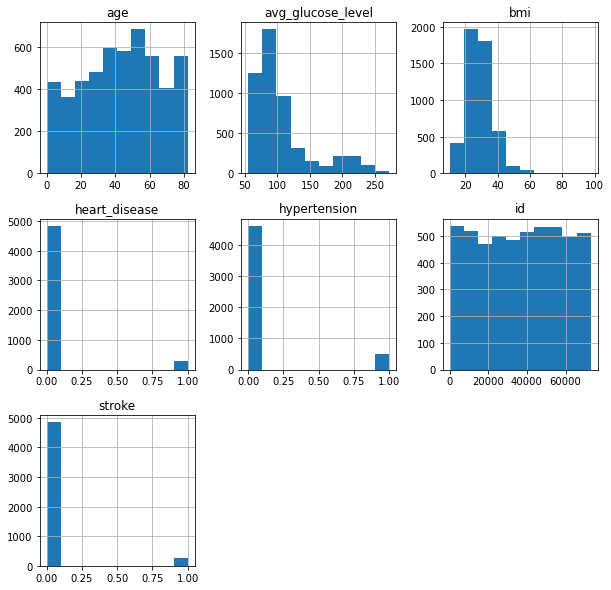

In [15]:
# distributions of different features
data.hist(figsize = (10,10))
plt.show()

* `age` is normally distributed with mean around 43
* `avg_glucose_level` and `bmi` follow a normal curve but are heavily skewed to the right side with many large outliers
* binary features such as `heart_disease` and `hypertension` have significant class imbalance
* target variable `stroke` is imbalanced

In [16]:
data['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

* there is heavy class imbalance amongst 5 different categories

In [17]:
data['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

* "Unknown" category may need to be imputed

In [18]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [19]:
# analyze correlations with inputs and target output stroke
data.corr()['stroke']

id                   0.006388
age                  0.245257
hypertension         0.127904
heart_disease        0.134914
avg_glucose_level    0.131945
bmi                  0.042374
stroke               1.000000
Name: stroke, dtype: float64

### Data Pipeline

In [20]:
# data before pipeline
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [21]:
# upsample minority class
from sklearn.utils import resample
print("Before balancing: ")
print(data['stroke'].value_counts())

df_minority = data[data.stroke == 1]
df_majority = data[data.stroke == 0]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=2000, random_state=123)
balanced = pd.concat([df_majority, df_minority_upsampled])
print("After balancing: ")
print(balanced['stroke'].value_counts())

data = balanced

Before balancing: 
0    4861
1     249
Name: stroke, dtype: int64
After balancing: 
0    4861
1    2000
Name: stroke, dtype: int64


In [58]:
# run cleanup in pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def run_pipeline(data, should_scale=True, verbose=False):
    processed_data = data

    # drop useless variables
    processed_data.drop(columns=['id'], inplace=True)
    
    # impute bad values
    imputer = SimpleImputer(missing_values="Other", strategy="most_frequent") 
    processed_data['gender'] = imputer.fit_transform(processed_data[['gender']]).ravel()
    imputer = SimpleImputer(missing_values=np.nan, strategy="median") 
    processed_data['bmi'] = imputer.fit_transform(processed_data[['bmi']]).ravel()
    imputer = SimpleImputer(missing_values="Unknown", strategy="most_frequent") 
    processed_data['smoking_status'] = imputer.fit_transform(processed_data[['smoking_status']]).ravel()
    
    # encode binary variables
    binary_replace = {
            "gender": {"Male": 1, "Female": 0},
            "ever_married": {"Yes": 1, "No": 0},
            "Residence_type": {"Rural": 1, "Urban": 0},
        }
    processed_data = processed_data.replace(binary_replace)
    
    # one hot encoding for categorical variables
    categoricals = ['work_type', 'smoking_status']
    one_hot_work = pd.get_dummies(processed_data['work_type'],prefix='work_type',drop_first=True)
    one_hot_smoking = pd.get_dummies(processed_data['smoking_status'],prefix='smoking_status',drop_first=True)
    processed_data = pd.concat([processed_data, one_hot_work, one_hot_smoking], axis=1)
    processed_data.drop(columns=categoricals, inplace=True)
    
    # augment feature
    processed_data['prexisting'] = processed_data['heart_disease'] | processed_data['hypertension']

    if verbose:
        print(processed_data.info())
        
    # scale data appropriately
    if should_scale:
        scaler = StandardScaler()
        scaler.fit(processed_data)
        processed_data = scaler.transform(processed_data)    
    
    return processed_data

In [56]:
# undersampling majority class to deal with imbalance
def equal_sampler(classes, data, target, test_frac):
    
    # Find the least frequent class and its fraction of the total
    _, count = np.unique(target, return_counts=True)
    fraction_of_total = min(count) / len(target)
    
    # split further into train and test
    train_frac = (1-test_frac)*fraction_of_total
    test_frac = test_frac*fraction_of_total
    
    # initialize index arrays and find length of train and test
    train, test = [], []
    train_len = int(train_frac * data.shape[0])
    test_len = int(test_frac* data.shape[0])
    
    # add values to train, drop them from the index and proceed to add to test
    for i in classes:
        indeces = list(target[target ==i].index.copy())
        train_temp = np.random.choice(indeces, train_len, replace=False)
        for val in train_temp:
            train.append(val)
            indeces.remove(val)
        test_temp = np.random.choice(indeces, test_len, replace=False)
        for val in test_temp:
            test.append(val)
    
    return data.loc[train], data.loc[test], target[train],  target[test] 

In [59]:
# train-test split 
from sklearn.model_selection import train_test_split

labels = data['stroke']
processed_data = data.drop(columns=['stroke'])

# without scaling and with undersampling
# processed_data = run_pipeline(processed_data, should_scale=False, verbose=True)
# x_train, x_test, y_train, y_test = equal_sampler([0,1], processed_data, labels, test_frac = 0.2)

# with scaling
processed_data = run_pipeline(processed_data, should_scale=True, verbose=True)
x_train, x_test, y_train, y_test = train_test_split(processed_data, labels, test_size = 0.2, stratify=labels)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6861 entries, 249 to 23
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       6861 non-null   int64  
 1   age                          6861 non-null   float64
 2   hypertension                 6861 non-null   int64  
 3   heart_disease                6861 non-null   int64  
 4   ever_married                 6861 non-null   int64  
 5   Residence_type               6861 non-null   int64  
 6   avg_glucose_level            6861 non-null   float64
 7   bmi                          6861 non-null   float64
 8   work_type_Never_worked       6861 non-null   uint8  
 9   work_type_Private            6861 non-null   uint8  
 10  work_type_Self-employed      6861 non-null   uint8  
 11  work_type_children           6861 non-null   uint8  
 12  smoking_status_never smoked  6861 non-null   uint8  
 13  smoking_status_smo

In [25]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5488, 15)
(5488,)
(1373, 15)
(1373,)


### Logistic Regression

In [26]:
# run logreg
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train, y_train)
y_predictions = logreg.predict(x_test)

In [27]:
print(f"Accuracy: {str(accuracy_score(y_test, y_predictions))}")
print(f"Precision: {str(precision_score(y_test, y_predictions))}")
print(f"Recall: {str(recall_score(y_test, y_predictions))}")
print(f"F1 Score: {str (f1_score(y_test, y_predictions))}")
print(f"Confusion matrix: {confusion_matrix(y_test, y_predictions)}")


Accuracy: 0.7800436999271668
Precision: 0.6269430051813472
Recall: 0.605
F1 Score: 0.6157760814249363
Confusion matrix: [[829 144]
 [158 242]]


In [61]:
# calculate p-values
import statsmodels.api as sm
model = sm.Logit(y_train, x_train)
model_fit = model.fit()
for var, p in enumerate(model_fit.pvalues):
    if p > 0.05:
        print('x' + str(var))

Optimization terminated successfully.
         Current function value: 0.556042
         Iterations 6
x2
x3
x7
x8
x10
x12
x13


The following features are significant to the logistic regression model
- hypertension
- heart_disease
- bmi 
- work_type_Never_worked
- work_type_Self_employed
- smoking_status_smokes  



### PCA

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6861 entries, 249 to 23
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6861 non-null   int64  
 1   gender             6861 non-null   object 
 2   age                6861 non-null   float64
 3   hypertension       6861 non-null   int64  
 4   heart_disease      6861 non-null   int64  
 5   ever_married       6861 non-null   object 
 6   work_type          6861 non-null   object 
 7   Residence_type     6861 non-null   object 
 8   avg_glucose_level  6861 non-null   float64
 9   bmi                6388 non-null   float64
 10  smoking_status     6861 non-null   object 
 11  stroke             6861 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 696.8+ KB


In [30]:
labels = data['stroke']
processed_data = data.drop(columns=['stroke'])
processed_data = run_pipeline(processed_data, should_scale=False)

In [31]:
labels.shape

(6861,)

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(processed_data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
labels.reset_index(drop=True, inplace=True)
principalDf.reset_index(drop=True, inplace=True)
finalDf = pd.concat([principalDf, labels], axis = 1)
print(finalDf)


      principal component 1  principal component 2  stroke
0                -24.552849              43.827101       0
1                -22.735596             -12.972908       0
2                 -8.234060              41.295420       0
3                -39.755485             -27.430418       0
4                 42.508669              42.890917       0
...                     ...                    ...     ...
6856             -34.901426             -36.269320       1
6857              99.555690             -17.996562       1
6858             136.315889              13.604884       1
6859              84.999673               4.854481       1
6860              99.555690             -17.996562       1

[6861 rows x 3 columns]


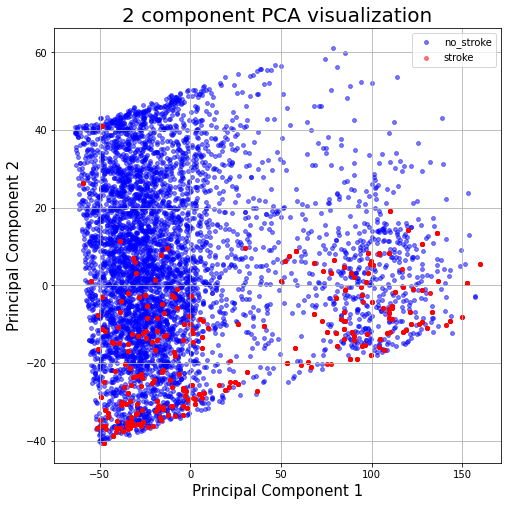

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA visualization', fontsize = 20)
targets = [0,1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['stroke'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 15, alpha=0.5)
ax.legend(['no_stroke', 'stroke'])
ax.grid()

### Ensemble

In [34]:
# train model and generate predictions
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier(n_estimators=10)
rfr = rfr.fit(x_train, y_train)
y_predictions = rfr.predict(x_test)

In [35]:
print(f"Accuracy: {str(accuracy_score(y_test, y_predictions))}")
print(f"Precision: {str(precision_score(y_test, y_predictions))}")
print(f"Recall: {str(recall_score(y_test, y_predictions))}")
print(f"F1 Score: {str (f1_score(y_test, y_predictions))}")
print(f"Confusion matrix: {confusion_matrix(y_test, y_predictions)}")


Accuracy: 0.9847050254916242
Precision: 0.9501187648456056
Recall: 1.0
F1 Score: 0.9744214372716199
Confusion matrix: [[952  21]
 [  0 400]]


### Neural Network

In [36]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=1000)
mlp = mlp.fit(x_train, y_train)
y_predictions = mlp.predict(x_test)

In [37]:
print(f"Accuracy: {str(accuracy_score(y_test, y_predictions))}")
print(f"Precision: {str(precision_score(y_test, y_predictions))}")
print(f"Recall: {str(recall_score(y_test, y_predictions))}")
print(f"F1 Score: {str (f1_score(y_test, y_predictions))}")
print(f"Confusion matrix: {confusion_matrix(y_test, y_predictions)}")


Accuracy: 0.954843408594319
Precision: 0.8658008658008658
Recall: 1.0
F1 Score: 0.9280742459396751
Confusion matrix: [[911  62]
 [  0 400]]


### Cross Validation

In [38]:
# generate datasets 
labels = data['stroke']
processed_data = data.drop(columns=['stroke'])

# run pipeline
processed_data = run_pipeline(processed_data, should_scale=True, verbose=False)

In [94]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import KFold

@ignore_warnings(category=ConvergenceWarning) # suppress convergence warning messages from NN models
def run_kfold(X_kfold, Y_kfold):
    # set up kfold 
    kf = KFold(n_splits=10, shuffle=True)

    # prep data
    X = X_kfold
    y = Y_kfold

    # train logistic model
    rfr_scores = []
    nn_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
        y_predictions = model.predict(X_test)
        rfr_scores.append(f1_score(y_test, y_predictions))
        model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=100).fit(X_train, y_train)
        y_predictions = model.predict(X_test)
        nn_scores.append(f1_score(y_test, y_predictions))

    print(f"Average F1 RFR: {sum(rfr_scores)/len(rfr_scores)}")
    print(f"Average F1 NN: {sum(nn_scores)/len(nn_scores)}")

run_kfold(processed_data, labels)



Average F1 RFR: 0.9799064035042973
Average F1 NN: 0.869700045963174


### Results